In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

#### + Erlotinib + AXL-activating Antibody (AF154)

In [3]:
ABC_ab = preprocessing(Axlmuts_ErlF154=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
ABC_ab = preprocess_seqs(ABC_ab, "Y").sort_values(by="Protein")

data_ab = ABC_ab.select_dtypes(include=['float64']).T
info_ab = ABC_ab.select_dtypes(include=['object'])

treatments_ab = ["PC9", "Knock-Out", "Kin. Dead", "Knock-In", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
data_ab.index = treatments_ab

In [4]:
# ABC_ab

### Phenotypes

#### Cell Viability of AXL mutant Cell Lines

In [5]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR1.csv").iloc[:, 1:]
cv1_ab = cv1.loc[:, cv1.columns.str.contains('-A/E')]
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR2.csv').iloc[:, 1:]
cv2_ab = cv2.loc[:, cv2.columns.str.contains('-A/E')]
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR3.csv').iloc[:, 1:]
cv3_ab = cv3.loc[:, cv2.columns.str.contains('-A/E')]

for ii in range(0, cv2_ab.columns.size):
    cv1_ab.iloc[:, ii] /= cv1_ab.iloc[0, ii]
    cv2_ab.iloc[:, ii] /= cv2_ab.iloc[0, ii]
    cv3_ab.iloc[:, ii] /= cv3_ab.iloc[0, ii]

cv = pd.concat([cv1_ab, cv2_ab, cv3_ab], axis=0)
cv.insert(0, "Elapsed",  cv1.iloc[:, 0])
cv =  MergeDfbyMean(cv, cv1_ab.columns, "Elapsed").reset_index()
CV_ab = cv[cv["Elapsed"] == 96].iloc[0, 1:]
CV_ab = CV_ab[["PC9-A/E", "AXL KO-A/E", "Kdead-A/E", "Kin-A/E", "M4-A/E", "M5-A/E", "M7-A/E", "M10-A/E", "M11-A/E", "M15-A/E"]]

CV_ab

PC9-A/E       9.159426
AXL KO-A/E    2.665736
Kdead-A/E     4.022231
Kin-A/E       6.597008
M4-A/E        5.483115
M5-A/E        5.406109
M7-A/E        7.814200
M10-A/E       7.187896
M11-A/E       7.657731
M15-A/E       4.835359
Name: 32, dtype: float64

# Chained MS mixed clustering + PLSR analysis

### + Erlotinib + AF154

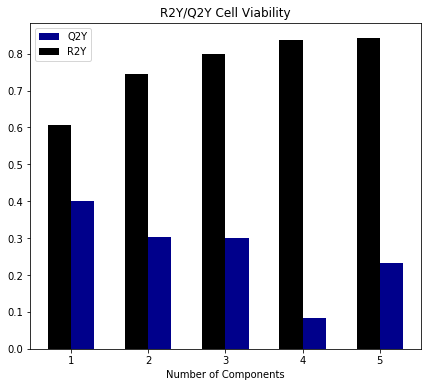

In [6]:
distance_method = "PAM250"
ncl = 5
GMMweight = 0.5

MSC = MassSpecClustering(info_ab, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(data_ab, CV_ab)
centers_ab = MSC.transform(data_ab)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, centers_ab, CV_ab, ncl+1)

In [7]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data_ab, info_ab, CV_ab, distance_method)

In [9]:
# scores = MSclusPLSR_tuning(data_ab, info_ab, CV_ab, distance_method)

In [10]:
# scores.sort_values(by="mean_test_score")

In [ ]:
# ncl_GMMweight_ncomp = CVresults_min.sort_values(by="Ranking").iloc[:21, :]
# ncl_GMMweight_ncomp

In [ ]:
# create_download_link(ncl_GMMweight_ncomp, "20200119-AxlMutants_GridSearch_PAM250_ErlAF154")

In [ ]:
# labels = []
# for ii in range(ncl_GMMweight_ncomp.shape[0]):
#     labels.append(str(ncl_GMMweight_ncomp.iloc[ii, 1]) + 
#                   "|" + str(ncl_GMMweight_ncomp.iloc[ii, 2]) + 
#                   "|" + str(ncl_GMMweight_ncomp.iloc[ii, 3]))

    
# fig, ax = plt.subplots(1,1,figsize=(25,10))

# width = 0.5
# ax.bar(np.arange(ncl_GMMweight_ncomp.shape[0]), np.abs(ncl_GMMweight_ncomp.iloc[:, 4]), width, edgecolor='black', color='g')
# ax.set_xticks(np.arange(ncl_GMMweight_ncomp.shape[0]))
# ax.set_xticklabels(labels, fontsize=12)
# ax.set_xlabel("#Clusters | #Components | GMM Weight", fontsize=16)
# ax.set_ylabel("Mean-Squared Error (MSE)", fontsize=16)
# ax.set_title("Top20 Hyperparameter Combinations", fontsize=20)

In [ ]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info_ab, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data_ab, CV_ab)
centers_ab = mixedCl_plsr.named_steps.mixedCl.transform(data_ab)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data_ab, CV_ab)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers_ab, CV_ab, ncl, treatments_ab)

In [ ]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC_ab.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, centers_ab.T, treatments_ab)

In [ ]:
clustermembers